In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import matplotlib.patches as mpatches
import os
import math
import random
from scipy.stats import ranksums
from scipy.stats import chi2_contingency

In [8]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [9]:
#modified is the normal gtf without the first two lines below
# stringtie --merge 60541_transcripts.gtf 60542_transcripts.gtf 60543_transcripts.gtf 60544_transcripts.gtf 60545_transcripts.gtf 60546_transcripts.gtf 60547_transcripts.gtf 60548_transcripts.gtf -o afran_genome_annotation_0.5.gtf -F 0 -T 0.5
# StringTie version 2.2.1
fran_gtf=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/1.stringtie/afran_genome_annotation_0.5_2_modified.gtf",sep="\t",header=None)
fran_gtf_2=fran_gtf[[0,2,3,8]]
fran_gtf_2=fran_gtf_2[fran_gtf_2[2]=='transcript']
fran_gtf_2['gene_id']=fran_gtf_2[8].str.split(';',expand=True)[0]
fran_gtf_2=fran_gtf_2[[0,2,3,'gene_id']].drop_duplicates(subset='gene_id', keep="first")
fran_gtf_2['gene_id']=fran_gtf_2['gene_id'].str[9:-1]

In [10]:
seurat_clusters=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/seurat_clusters_cells_integrated_DUBStepR_3_2.txt",sep=",")

In [11]:
normalized_exp=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/normalized_expression_DUBStepR_3_2.csv",sep=",",low_memory=False)
#normalized_exp=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/counts_DUBStepR_3_2.csv",sep=",",low_memory=False)

In [12]:
merged_normalized=pd.merge(normalized_exp,fran_gtf_2,left_on='gene',right_on='gene_id')

In [13]:
del normalized_exp

In [14]:
W_scaffolds=['scaffold000049W',
'scaffold000218W',
'scaffold000121W',
'scaffold000336W',
'scaffold000179W',
'scaffold000243W',
'scaffold000334W',
'scaffold000030W',
'scaffold000094W',
'scaffold000085W',
'scaffold000133W',
'scaffold000315W',
'scaffold000444W',
'scaffold000018W',
'scaffold000222W',
'scaffold000265W',
'scaffold000119W',
'scaffold000294W',
'scaffold000196W',
'scaffold000043W',
'scaffold000136W',
'scaffold000131W',
'scaffold000032W',
'scaffold000274W',
'scaffold000023W',
'scaffold000046W',
'scaffold000324W',
'scaffold000330W',
'scaffold000370W',
'scaffold000183W',
'scaffold000141W',
'scaffold000272W',
'scaffold000232W',
'scaffold000031W',
'scaffold000132W',
'scaffold000116W',
'scaffold000152W',
'scaffold000068W']

In [15]:
merged_all_norm=merged_normalized[merged_normalized[0].str.contains('chr')|merged_normalized[0].isin(W_scaffolds)]

In [16]:
def windows_and_strata(strata,df2,seurat_clusters):
    df=df2.copy()
    df.loc[
      ((df[0]=='chr6')&(df[3]<=45665001)), 
      'strata'+str(strata)
    ] = 'pseudo'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 45665001.0) & (df[3] <= 48665001))))
    , 
      'strata'+str(strata)
    ] = 'S1'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 48665001) & (df[3] <= 53325001))|((df[3] > 53585001) & (df[3] <= 54575001))|((df[3] > 54735001) & (df[3] <= 61725001))))
    , 
      'strata'+str(strata)
    ] = 'S0'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 61725001.0) & (df[3] <= 66725001))))
    , 
      'strata'+str(str(strata))
    ] = 'S2'
    df.loc[
      ((df[0].str.contains('W'))), 
      'strata'+str(strata)
    ] = 'W'
    print(strata)
    for j in [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]:
        for i in np.arange(0,math.floor(len(df[df[0]=='chr'+str(j)])/len(df[df['strata'+str(strata)]==str(strata)])),1):
            df.loc[df['gene'].isin(df[df[0]=='chr'+str(j)][i*len(df[df['strata'+str(strata)]==str(strata)]):(i*len(df[df['strata'+str(strata)]==str(strata)])+len(df[df['strata'+str(strata)]==str(strata)]))]['gene'].tolist()), 'strata' +str(strata)] = 'chr'+str(j)+'bin' +str(i)
    df_2=df.drop([0,2,3,'gene','gene_id'],axis=1).groupby(["strata"+strata]).mean().T.reset_index()
    df_3=pd.merge(seurat_clusters,df_2,left_on='barcodes',right_on='index')
    columns= df_3.filter(regex='chr').columns.tolist()
    for i in columns:
        df_3[i]=np.log2((df_3[str(strata)]+0.00001)/(df_3[str(i)]+0.00001))
        df_3 = df_3.rename(columns={i: str(strata)+'/'+i})
    return df_3,df

In [17]:
S0_results,S0_results_raw=windows_and_strata('S0',merged_all_norm,seurat_clusters)
pseudo_results,pseudo_results_raw=windows_and_strata('pseudo',merged_all_norm,seurat_clusters)

S0
pseudo


In [18]:
S0_results['mean_all_rows_S0']=S0_results.filter(regex='S0/chr').mean(axis=1)
S0_results['mean_all_rows_S0']=S0_results['mean_all_rows_S0']-np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_S0'])
pseudo_results['mean_all_rows_pseudo']=pseudo_results.filter(regex='pseudo/chr').mean(axis=1)
pseudo_results['mean_all_rows_pseudo']=pseudo_results['mean_all_rows_pseudo']-np.median(pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_pseudo'])

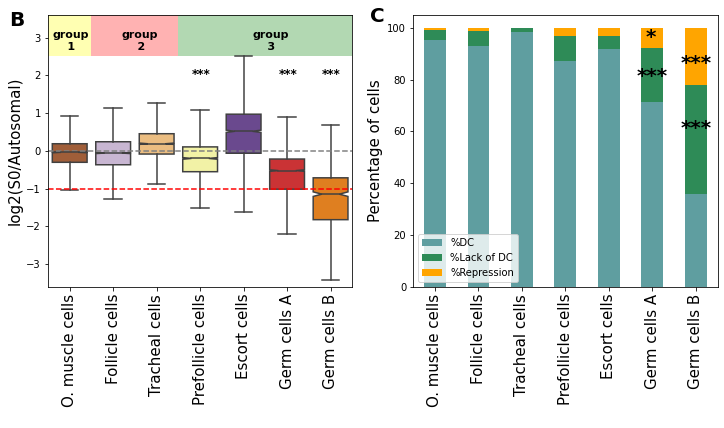

In [16]:
#plt.figure(figsize=(10, 5))
#plt.subplot(2,1,0)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
my_pal={12:	"#BC81FF",14:"#E26EF7",
17:	"#FF62BF",
18:	"#FF6A9A",
4:	"#00BDD4",
9:	"#00B5EE",
1:	"#00BD61",
5:	"#00C0B4",
6:	"#F8766D",
10:	"#00A7FF",
11:	"#7F96FF",
2:	"#BC9D00",
7:	"#00C08E",
15:	"#F863DF",
16:	"#E9842C",
0:	"#D69100",
3:	"#9CA700",
13:	"#6FB000",
8:	"#00B813"}
my_pal ={0:'#cab2d6',1:'#e31a1c',2:'#b15928',3:'#6a3d9a',4:'#fdbf6f',5:'#ffff99',6:'#ff7f00'}
sns.boxplot(x='seurat_clusters', y='mean_all_rows_S0', data=S0_results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[0],notch=True)
axes[0].hlines(np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_S0']),-0.5,6.5,color="gray",linestyle='dashed')
axes[0].hlines(np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_S0'])-1,-0.5,6.5,color="red",linestyle='dashed')
#axes[0].hlines(np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])+1,-0.5,6.5,color="red",linestyle='dashed')
#axes[0].vlines(0.5,-3.6,3,color="black",linewidth=1)
#axes[0].vlines(2.5,-3.6,3,color="black",linewidth=1)
axes[0].text(4.2, 3.2, 'group\n    3',fontsize=11, fontweight='bold', va='top')
axes[0].text(-1.4, 3.7, 'B',fontsize=20, fontweight='bold', va='top')
axes[0].text(1.2, 3.2, 'group\n    2',fontsize=11, fontweight='bold', va='top')
axes[0].text(-0.4, 3.2, 'group\n    1',fontsize=11,fontweight='bold', va='top')
axes[0].set_ylim(ymax=3.6,ymin=-3.6)
axes[0].fill_between([2.5,6.5], 2.5, 4,facecolor='green', alpha=0.3,zorder=0)
axes[0].fill_between([0.5,2.5], 2.5, 4,facecolor='red', alpha=0.3,zorder=0)
axes[0].fill_between([-0.5,0.5],2.5, 4,facecolor='yellow', alpha=0.3,zorder=0)
axes[0].set_ylabel('log2(S0/Autosomal)',fontsize=15)
axes[0].set_xlabel(' ')
axes[0].text(2.8, 2.2, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([5])]['mean_all_rows_S0'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_S0'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(4.8, 2.2, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([1])]['mean_all_rows_S0'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_S0'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(5.8, 2.2, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([6])]['mean_all_rows_S0'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_S0'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[0].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=15)
exp=S0_results
exp['mean_all_rows']=exp['mean_all_rows_S0']
exp.loc[
  (exp['mean_all_rows']>np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5)), 
  'zone'
] = 'DC'
exp.loc[
  (exp['mean_all_rows']<=np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5))&(exp['mean_all_rows']>np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows']-1,5)), 
  'zone'
] = 'Lack of DC'
exp.loc[
  (exp['mean_all_rows']<=np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows']-1,5)), 
  'zone'
] = 'Repression'
Zones_1=pd.DataFrame(exp.groupby('seurat_clusters')['zone'].value_counts()).unstack(fill_value=0).reset_index(drop=True).reset_index(drop=True)
Zones_1=Zones_1['zone'].reset_index()
Zones_1['%DC']=(Zones_1['DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Repression']=(Zones_1['Repression']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Lack of DC']=(Zones_1['Lack of DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
exp_plot=Zones_1[["%DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).plot.bar(stacked=True,color=['cadetblue','seagreen',"orange"],ax=axes[1])
exp_plot.legend(loc=3) 
plt.ylabel("Percentage of cells",fontsize=15)
axes[1].set_xlabel(' ')
Zones_1_stats=Zones_1[["%DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).T.reset_index()#[[2,1]]
#Zones_1_stats['somatic']=np.median([Zones_1_stats[2].astype(float),Zones_1_stats[0].astype(float),Zones_1_stats[4].astype(float)])
Zones_1_stats['somatic']=Zones_1_stats[[2,0,4]].median(axis=1)
Zones_1_stats=Zones_1_stats.drop([2,0,4],axis=1)
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%Not_repressed']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Lack of DC'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%No_Lack_of_DC']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Repression'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats_N=Zones_1_stats[(Zones_1_stats['zone']=='%DC')|(Zones_1_stats['zone']=="%Lack of DC")|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NI=Zones_1_stats[(Zones_1_stats['zone']=='%Not_repressed')|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NDC=Zones_1_stats[(Zones_1_stats['zone']=='%No_Lack_of_DC')|(Zones_1_stats['zone']=="%Lack of DC")]
axes[1].text(4.65, 85, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(4.85, 100, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(5.65, 65, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(5.65, 90, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(-1.5, 108, 'C',fontsize=20, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[1].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=15)
#plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/Repression_GEX_v3.png',bbox_inches='tight',facecolor='white')

In [19]:
S1_results,S1_results_raw=windows_and_strata('S1',merged_all_norm,seurat_clusters)
S2_results,S2_results_raw=windows_and_strata('S2',merged_all_norm,seurat_clusters)
pseudo_results,pseudo_results_raw=windows_and_strata('pseudo',merged_all_norm,seurat_clusters)
W_results,W_results_raw=windows_and_strata('W',merged_all_norm,seurat_clusters)
S1_results['mean_all_rows']=S1_results.filter(regex='S1/chr').mean(axis=1)
S1_results['mean_all_rows']=S1_results['mean_all_rows']-np.median(S1_results[S1_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])
S2_results['mean_all_rows']=S2_results.filter(regex='S2/chr').mean(axis=1)
S2_results['mean_all_rows']=S2_results['mean_all_rows']-np.median(S2_results[S2_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])
pseudo_results['mean_all_rows']=pseudo_results.filter(regex='pseudo/chr').mean(axis=1)
pseudo_results['mean_all_rows']=pseudo_results['mean_all_rows']-np.median(pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])
W_results['mean_all_rows']=W_results.filter(regex='W/chr').mean(axis=1)
W_results['mean_all_rows']=W_results['mean_all_rows']-np.median(W_results[W_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])


S1
S2
pseudo
W


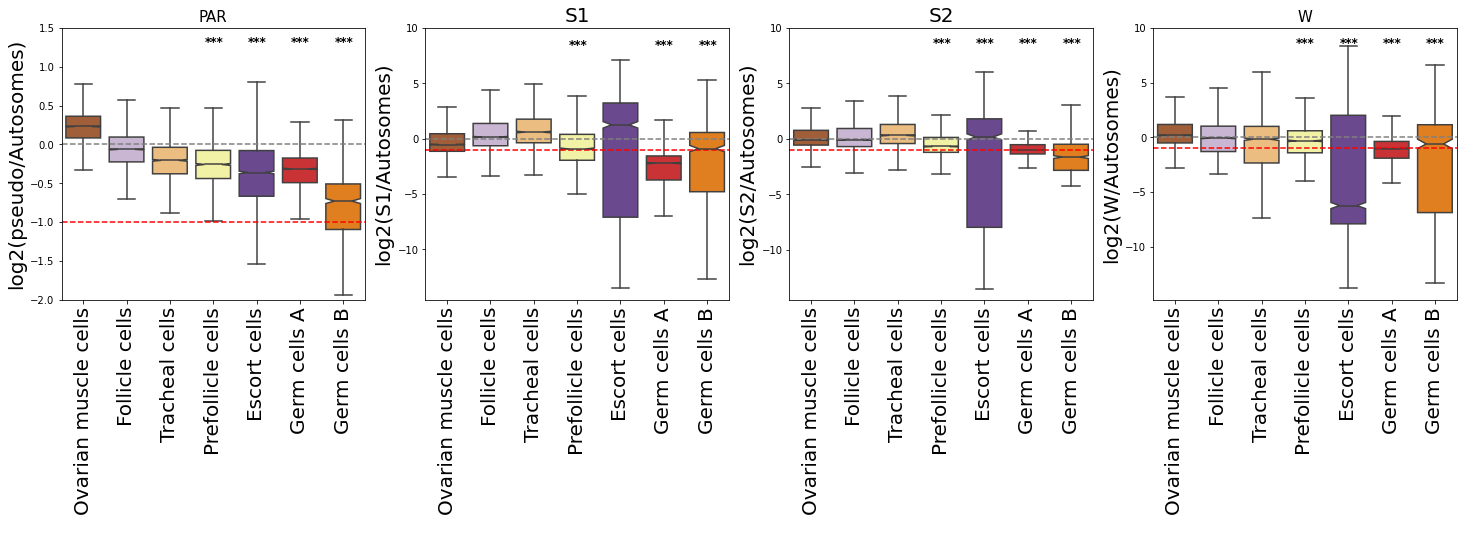

In [20]:
#plt.figure(figsize=(10, 5))
#plt.subplot(2,1,0)
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(25, 5))
my_pal={12:	"#BC81FF",14:"#E26EF7",
17:	"#FF62BF",
18:	"#FF6A9A",
4:	"#00BDD4",
9:	"#00B5EE",
1:	"#00BD61",
5:	"#00C0B4",
6:	"#F8766D",
10:	"#00A7FF",
11:	"#7F96FF",
2:	"#BC9D00",
7:	"#00C08E",
15:	"#F863DF",
16:	"#E9842C",
0:	"#D69100",
3:	"#9CA700",
13:	"#6FB000",
8:	"#00B813"}
my_pal ={0:'#cab2d6',1:'#e31a1c',2:'#b15928',3:'#6a3d9a',4:'#fdbf6f',5:'#ffff99',6:'#ff7f00'}
sns.boxplot(x='seurat_clusters', y='mean_all_rows', data=pseudo_results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[0],notch=True)
axes[0].hlines(np.median(pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows']),-0.5,6.5,color="gray",linestyle='dashed')
axes[0].hlines(np.median(pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])-1,-0.5,6.5,color="red",linestyle='dashed')
axes[0].set_ylim(ymax=1.5,ymin=-2)
#axes[0].set_ylim(ymax=10,ymin=-10)
#axes[0].fill_between([2.5,6.5], 2, 3,facecolor='green', alpha=0.5)
#axes[0].fill_between([0.5,2.5], 2, 3,facecolor='red', alpha=0.5)
#axes[0].fill_between([-0.5,0.5], 2, 3,facecolor='yellow', alpha=0.5)
axes[0].set_title('PAR',fontsize=15)
axes[0].set_ylabel('log2(pseudo/Autosomes)',fontsize=20)
axes[0].set_xlabel(' ')
axes[0].text(2.8, 1.4, convert_pvalue_to_asterisks(ranksums(pseudo_results[pseudo_results['seurat_clusters'].isin([5])]['mean_all_rows'],pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(3.8, 1.4, convert_pvalue_to_asterisks(ranksums(pseudo_results[pseudo_results['seurat_clusters'].isin([3])]['mean_all_rows'],pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(4.8, 1.4, convert_pvalue_to_asterisks(ranksums(pseudo_results[pseudo_results['seurat_clusters'].isin([1])]['mean_all_rows'],pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(5.8, 1.4, convert_pvalue_to_asterisks(ranksums(pseudo_results[pseudo_results['seurat_clusters'].isin([6])]['mean_all_rows'],pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
region = ['Ovarian muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[0].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=20)
sns.boxplot(x='seurat_clusters', y='mean_all_rows', data=S1_results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[1],notch=True)
axes[1].hlines(np.median(S1_results[S1_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows']),-0.5,6.5,color="gray",linestyle='dashed')
axes[1].hlines(np.median(S1_results[S1_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])-1,-0.5,6.5,color="red",linestyle='dashed')
#axes[1].text(4.2, 2.8, 'group 3',fontsize=10, fontweight='bold', va='top')
#axes[1].text(-0.4, 2, 'A',fontsize=20, fontweight='bold', va='top')
#axes[1].text(1.3, 2.8, 'group 2',fontsize=10, fontweight='bold', va='top')
#axes[1].text(-0.4, 2.8, 'group 1',fontsize=10, fontweight='bold', va='top')
axes[1].set_ylim(ymax=10)
#axes[1].set_ylim(ymax=1.5,ymin=-2)
#axes[1].fill_between([2.5,6.5], 7.5, 10,facecolor='green', alpha=0.5)
#axes[1].fill_between([0.5,2.5], 2, 3,facecolor='red', alpha=0.5)
#axes[1].fill_between([-0.5,0.5], 2, 3,facecolor='yellow', alpha=0.5)
axes[1].set_ylabel('log2(S1/Autosomes)',fontsize=20)
axes[1].set_xlabel(' ')
axes[1].text(2.8, 9, convert_pvalue_to_asterisks(ranksums(S1_results[S1_results['seurat_clusters'].isin([5])]['mean_all_rows'],S1_results[S1_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
#axes[1].text(3.8, 9, convert_pvalue_to_asterisks(ranksums(S1_results[S1_results['seurat_clusters'].isin([3])]['mean_all_rows'],S1_results[S1_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1].text(4.8, 9, convert_pvalue_to_asterisks(ranksums(S1_results[S1_results['seurat_clusters'].isin([1])]['mean_all_rows'],S1_results[S1_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1].text(5.8, 9, convert_pvalue_to_asterisks(ranksums(S1_results[S1_results['seurat_clusters'].isin([6])]['mean_all_rows'],S1_results[S1_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1].set_title('S1',fontsize=20)
region = ['Ovarian muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[1].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=20)
axes[1].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=20)
sns.boxplot(x='seurat_clusters', y='mean_all_rows', data=S2_results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[2],notch=True)
axes[2].hlines(np.median(S2_results[S2_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows']),-0.5,6.5,color="gray",linestyle='dashed')
axes[2].hlines(np.median(S2_results[S2_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])-1,-0.5,6.5,color="red",linestyle='dashed')
#axes[2].text(4.2, 2.8, 'group 3',fontsize=10, fontweight='bold', va='top')
#axes[2].text(-0.4, 2, 'A',fontsize=20, fontweight='bold', va='top')
#axes[2].text(1.3, 2.8, 'group 2',fontsize=10, fontweight='bold', va='top')
#axes[2].text(-0.4, 2.8, 'group 1',fontsize=10, fontweight='bold', va='top')
axes[2].set_ylim(ymax=10)
#axes[2].set_ylim(ymax=1.5,ymin=-2)
#axes[2].fill_between([2.5,6.5], 2, 3,facecolor='green', alpha=0.5)
#axes[2].fill_between([0.5,2.5], 2, 3,facecolor='red', alpha=0.5)
#axes[2].fill_between([-0.5,0.5], 2, 3,facecolor='yellow', alpha=0.5)
axes[2].set_ylabel('log2(S2/Autosomes)',fontsize=20)
axes[2].set_xlabel(' ')
axes[2].text(2.8, 9.2, convert_pvalue_to_asterisks(ranksums(S2_results[S2_results['seurat_clusters'].isin([5])]['mean_all_rows'],S2_results[S2_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[2].text(3.8, 9.2, convert_pvalue_to_asterisks(ranksums(S2_results[S2_results['seurat_clusters'].isin([3])]['mean_all_rows'],S2_results[S2_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[2].text(4.8, 9.2, convert_pvalue_to_asterisks(ranksums(S2_results[S2_results['seurat_clusters'].isin([1])]['mean_all_rows'],S2_results[S2_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[2].text(5.8, 9.2, convert_pvalue_to_asterisks(ranksums(S2_results[S2_results['seurat_clusters'].isin([6])]['mean_all_rows'],S2_results[S2_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[2].set_title('S2',fontsize=20)
region = ['Ovarian muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[2].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=20)
sns.boxplot(x='seurat_clusters', y='mean_all_rows', data=W_results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[3],notch=True)
axes[3].hlines(np.median(W_results[W_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows']),-0.5,6.5,color="gray",linestyle='dashed')
axes[3].hlines(np.median(W_results[W_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])-1,-0.5,6.5,color="red",linestyle='dashed')
#axes[2].text(4.2, 2.8, 'group 3',fontsize=10, fontweight='bold', va='top')
#axes[2].text(-0.4, 2, 'A',fontsize=20, fontweight='bold', va='top')
#axes[2].text(1.3, 2.8, 'group 2',fontsize=10, fontweight='bold', va='top')
#axes[2].text(-0.4, 2.8, 'group 1',fontsize=10, fontweight='bold', va='top')
axes[3].set_ylim(ymax=10)
#axes[3].set_ylim(ymax=1.5,ymin=-2)
#axes[2].fill_between([2.5,6.5], 2, 3,facecolor='green', alpha=0.5)
#axes[2].fill_between([0.5,2.5], 2, 3,facecolor='red', alpha=0.5)
#axes[2].fill_between([-0.5,0.5], 2, 3,facecolor='yellow', alpha=0.5)
axes[3].set_ylabel('log2(W/Autosomes)',fontsize=20)
axes[3].set_xlabel(' ')
axes[3].set_title('W',fontsize=15)
axes[3].text(2.8, 9.2, convert_pvalue_to_asterisks(ranksums(W_results[W_results['seurat_clusters'].isin([5])]['mean_all_rows'],W_results[W_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[3].text(3.8, 9.2, convert_pvalue_to_asterisks(ranksums(W_results[W_results['seurat_clusters'].isin([3])]['mean_all_rows'],W_results[W_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[3].text(4.8, 9.2, convert_pvalue_to_asterisks(ranksums(W_results[W_results['seurat_clusters'].isin([1])]['mean_all_rows'],W_results[W_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[3].text(5.8, 9.2, convert_pvalue_to_asterisks(ranksums(W_results[W_results['seurat_clusters'].isin([6])]['mean_all_rows'],W_results[W_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
region = ['Ovarian muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[3].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=20)
#plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/repression_all_Z_v3.png',bbox_inches='tight',facecolor='white')
